# Proyecto
## Tienda online **`ice`**
#### Descripción del proyecto

Trabajas para la tienda online **Ice** que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que **identificar patrones** que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Delante de ti hay **datos que se remontan a 2016**. Imaginemos que es diciembre de 2016 y estás planeando una campaña para 2017.

Lo importante es adquirir experiencia de trabajo con datos. Realmente no importa si estás pronosticando las ventas de 2017 en función de los datos de 2016 o las ventas de 2027 en función de los datos de 2026.

El dataset contiene una columna "`rating`" que almacena la clasificación ESRB de cada juego. El Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento) evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.

### Paso 1. Abrir archivo y estudiar información general

In [1]:
# Primero voy a importar las librerías
from scipy import stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importar información
df_games = pd.read_csv('datasets/games.csv')

In [3]:
df_games.info()

df_games.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


De cajón se puede observar que hay 2 juegos con nombres ausentes. Lo veré más adelante en la preparación de datos.

Con respecto a *plataforma, género y ventas de todas las regiones* **no hay valores nulos**, lo cual es un alivio.

El año de lanzamiento es flotante, lo cual se tiene que cambiar por obvias razones.

Los puntajes no son consistentes, algunos son de 0 a 100 y el otro de 0 a 10. Esto se tiene que arreglar. Además de que tienen bastantes valores ausentes.

El rating también tiene valores ausentes lo cual puede ser un problema. También se tiene que resolver.

### Paso 2. Preparar los datos

#### Funciones
Voy a escribir unas funciones para optimizar un poco el código

In [4]:
# Función para retornar una proporción, redondeado a 2 dígitos
def calcularProporcion(faltante, total):
    return round(faltante / total * 100, 2)

#### Nombres de las columnas

In [5]:
# Reemplazar los nombres de las columnas
df_games.columns = df_games.columns.str.lower()

#### Valores ausentes
##### Columna nombres

In [6]:
# Valores ausentes en nombres
print(f"Cantidad de nombres faltantes: {df_games['name'].isna().sum()}")

Cantidad de nombres faltantes: 2


Solamente hay 2 registros con nombre nulo, por lo que no nos tenemos que preocupar por esto.

In [7]:
# Borrar estos registros con valores nulos, ya que son irrelevantes
df_games = df_games[~df_games['name'].isna()]

##### Columna del año de lanzamiento

In [8]:
# Contar el total de juegos
total_games_count = len(df_games)

# Calcular la cantidad de registros con año de lanzamiento nulo
años_faltantes = df_games['year_of_release'].isna().sum()

# Proporción de faltantes
prop_años = calcularProporcion(años_faltantes, total_games_count)
print(f"Proporcion de columnas de año de lanzamiento con valores nulos: %{prop_años}")

Proporcion de columnas de año de lanzamiento con valores nulos: %1.61


El %1.61 de registros no tienen el año de lanzamiento, no es una proporcion significativa, vamos a eliminarlos porque no representaría una alteración significativa para nuestros cálculos.

In [9]:
# Borrar estos registros con valores nulos, ya que son irrelevantes
df_games = df_games[~df_games['year_of_release'].isna()]

##### Columna de crítica

In [10]:
# Calcular cantidad de registros con calificaciones nulas
cal_crit_faltante = df_games['critic_score'].isna().sum()

# Calcular proporciones
prop_crit = calcularProporcion(cal_crit_faltante, total_games_count)

print(f"Proporcion de columnas de calificación de la crítica con valores nulos: %{prop_crit}")

Proporcion de columnas de calificación de la crítica con valores nulos: %50.63


Podemos ver que hay un porcentaje significativamente alto en proporción a la cantidad de registros con valores nulos, sería muy costoso para nuestros calculos, por esto no los podemos ignorar. Voy a reemplazar los valores nulos con promedios.

In [11]:
# Rellena los valores nulos con las calificaciones promedio dependiendo del género del juego
df_games['critic_score'] = df_games.groupby('genre')['critic_score'].transform(
    lambda x: x.fillna(x.mean())
)

##### Columna de calificaciones de usuarios

In [12]:
# Calcular cantidad de registros con calificaciones nulas
cal_user_faltante = df_games['user_score'].isna().sum()

# Calcular proporciones
prop_user = calcularProporcion(cal_user_faltante, total_games_count)

print(f"Proporcion de columnas de calificación de usuarios con valores nulos: %{prop_user}")

Proporcion de columnas de calificación de usuarios con valores nulos: %39.52


Aquí también tenemos un porcentaje significativo de valores nulos, pero no solo eso, también tenemos muchos valores con 'tbd'.

In [13]:
# Registros con 'tbd'
count_tbd = (df_games['user_score'] == 'tbd').sum()

# Calcular proporcion con valores 'tbd'
prop_tbd = calcularProporcion(count_tbd, total_games_count)

print(f"Proporcion de registros con 'tbd': %{prop_tbd}")

Proporcion de registros con 'tbd': %14.22


Tenemos más de un %50 de registros con valores que NO son calificaciones.

No creo que pueda asignar algún valor a estos registros porque podría dar pie a sesgos en los cálculos. Voy a optar por **hacer que los 'tbd' sean valores nulos**, y voy a usar esta columna como variable secundaria, sólo lo voy a usar para análisis donde esté disponible.

Siendo que hay demasiados registros con esta columna nula, no puedo simplemente eliminar esos registros, pero tampoco voy a usar esta columna para cosas tan relevantes por el hecho de que más de la mitad de esta columna es inútil.

In [14]:
# Cambiar 'tbd' a nulos
df_games['user_score'] = df_games['user_score'].replace('tbd', np.nan)

##### Columna de rating

In [15]:
# Calcular cantidad de registros con rating nulos
rating_faltante = df_games['rating'].isna().sum()

# Calcular proporciones
prop_rating = calcularProporcion(rating_faltante, total_games_count)

print(f"Proporcion de columnas de rating con valores nulos: %{prop_rating}")

Proporcion de columnas de rating con valores nulos: %39.94


Hay un porcentaje significativo de juegos sin rating, no se pueden simplemente ignorar.

Analizando los datos más a fondo veo que no hay algún patrón claro para poder hacer calificaciones intuitivas, por ejemplo, podría asumir que los Shooter automáticamente los puedo marcar con rating M, pero hay juegos que son Shooter calificados como E10+ y T, así que no se puede rellenar intuitivamente esta columna, por lo que voy a dejar estos juegos con rating `unrated`, ya que es transparente para análisis posteriores.

In [16]:
df_games['rating'] = df_games['rating'].fillna('Unrated')

##### ¿Por qué hay valores nulos?

Con respecto al `year_of_release` puede que los valores nulos se deban a que pueden haber juegos muy antiguos sin registro exacto de lanzamientos, por ports/remasters que tienen fechas ambiguas resultado de la reutilización de código base en versiones anteriores.

Con `critic_score` puede tener valores nulos debido a la cobertura de las organizaciones de crítica, tal vez no cubren juegos indies. Tal vez depende del lanzamiento regional, tal vez hay títulos lanzados en japón o europa y no hay registros de medios globales que califiquen los juegos, o por lo menos no según la información extraída para este análisis.

En `user_score` puede tener una mezcla de factores como la columna anterior, o puede haber diferentes factores como la anitüedad de los juegos, en los juegos más antiguos es donde más se ven valores nulos. Con respecto a 'tbd', teniendo en cuenta que los valores son de 2016 y los estamos usando para hacer estimaciones para 2017 **podríamos** especular que al momento de extracción de la información se encuentra desactualizada la información debido a que es muy reciente, PERO analizando más a fondo los registros con 'tbd' puedo ver que hay cientos de juegos con bastante antigüedad, algunos teniendo ya 5 años de antiguedad a la extracción de los datos. Aquí solamente me resta especular que hay una falta de dedicación por parte de las organizaciones correspondientes para recopilar las calificaciones de los usuarios, o de a plano hay incompetencia para determinar el mismo.

Y con `rating` puede haber valores nulos debido a que hay juegos en las que no calsifica el rating ESRB, ya sea porque son bundles o por alguna otra razón específica como ediciones especiales con versión física limitadas sin proceso formal de rating. Pero dado que hay una cantidad significativa de valores nulos en esta columna, es difícil especular.

En general algunos de los valores nulos correspondientes a calificaciones se puede deber al tipo de cobertura que tenga el juego, sea por la region donde fue vendida, tanto como la categoría del juego, por ejemplo cuando un juego se vende como bundle o paquete de 2 o más juegos en una venta.

Como sea, a algunos de los valore nulos se podría atribuir a error de captura o extracción de información sea por cuestiones técnicas o por recolección de múltiples fuentes, pero eso es difícil de determinar.

#### Conversión de datos a los correspondientes

In [ ]:
# year_of_release float -> int
df_games['year_of_release'] = df_games['year_of_release'].astype(int)

# critic_score float -> int
df_games['critic_score'] = np.round(df_games['critic_score']).astype('Int64')

# user_score primero convertir object -> float, multiplicar por 10 y entonces float -> int
user_score_float = pd.to_numeric(df_games['user_score'])
df_games['user_score'] = (user_score_float * 10).astype('Int64')

In [18]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  Int64  
 9   user_score       7463 non-null   Int64  
 10  rating           16444 non-null  object 
dtypes: Int64(2), float64(4), int64(1), object(4)
memory usage: 1.5+ MB


Estos tipos de datos los convertí así por las siguientes razones:
- `year_of_release` no necesita explicación, no tiene sentido que sea float.
- `critic_score` lo cambié a entero siendo que no es necesario el uso de decimales siendo que es una escala de 0 a 100, además de que ningún registro tiene decimales en esta columna.
- `user_score` lo cambié a enteros igual, pero como era una escala de 0 a 10 con decimales, lo multipliqué por 10 por 2 razones; al hacerlo escala de 0 a 100 ya se puede convertir a entero sin perder calificaciones (ya que de todas formas seguía una escala de calificación igual de 0 a 100, pero con decimales), y también esto nos va a servir para poder hacer cálculos y comparaciones con la columna 'critic_score', ya que al finales tienen propósitos afines.

**¿Por qué no cambié el formato de ventas?**

No vi necesario hacer ningún tipo de movimientos a esos ya que tenemos a nuestra disposición que esos números "pequeños" son representaciones de millones de su valor. Además no veo ningún problema con los números que ya hay, no veo inconsistencias ni valores nulos.

In [20]:
# Calcular ventas totales con todas las regiones
df_games['global_sales'] = np.round(df_games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1), 2)

df_games[['name', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']].head(10)

,name,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,Wii Sports,41.36,28.96,3.77,8.45,82.54
1,Super Mario Bros.,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,15.68,12.76,3.79,3.29,35.52
3,Wii Sports Resort,15.61,10.93,3.28,2.95,32.77
4,Pokemon Red/Pokemon Blue,11.27,8.89,10.22,1.00,31.38
5,Tetris,23.20,2.26,4.22,0.58,30.26
6,New Super Mario Bros.,11.28,9.14,6.50,2.88,29.80
7,Wii Play,13.96,9.18,2.93,2.84,28.91
8,New Super Mario Bros. Wii,14.44,6.94,4.70,2.24,28.32
9,Duck Hunt,26.93,0.63,0.28,0.47,28.31


### Paso 3. Analizar datos

**Mira cuántos juegos fueron lanzados en diferentes años. ¿Son significativos los datos de cada período?**

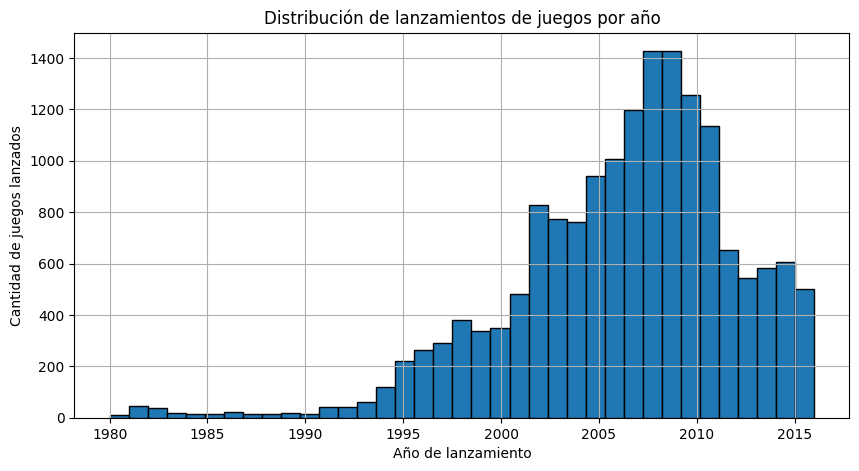

In [23]:
#df_games['year_of_release'].value_counts().sort_index()

df_games['year_of_release'].plot(
    kind='hist',
    bins=37,
    edgecolor='black',
    figsize=(10, 5),
    title='Distribución de lanzamientos de juegos por año'
)
plt.xlabel('Año de lanzamiento')
plt.ylabel('Cantidad de juegos lanzados')
plt.grid(True)
plt.show()

Se puede ver que en la década de los 80's casi es insignificativo la cantidad de lanzamientos que hay enc omparación al resto del histograma.

Empieza a empezar el auge de los videojuegos en la década de los 90's, subiendo gradualmente teniendo un pico entre 2005 y 2010, en concreto parece tener pico en 2008, superando los 1400 lanzamientos por año.

Hay una caída de lanzamientos después de 2010, manteniendose relativamente estable alrededor de 600 lanzamientos por año.

**Observa cómo varían las ventas de una plataforma a otra. Elige las plataformas con las mayores ventas totales y construye una distribución basada en los datos de cada año. Busca las plataformas que solían ser populares pero que ahora no tienen ventas. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?**

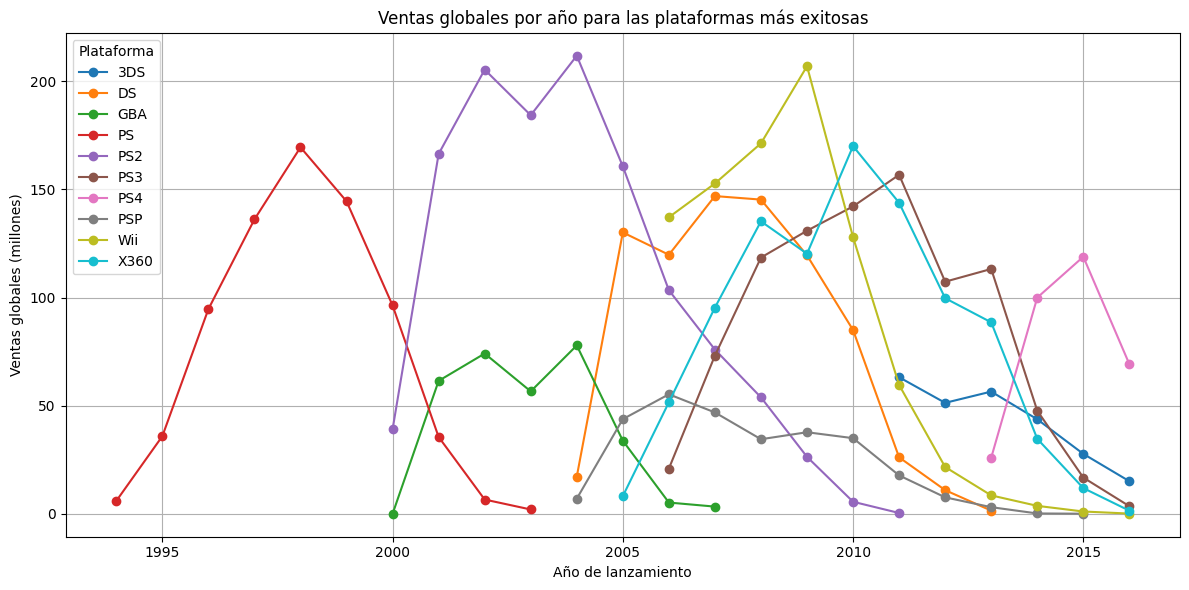

In [32]:
# Ver ventas totales por plataforma en orden
platform_sales = df_games.groupby('platform')['global_sales'].sum().sort_values(ascending=False)

# Sleccionar las mejores plataformas
top_platforms = platform_sales.head(10).index.tolist()

# Filtrar el df
sales_filtered_df = df_games[df_games['platform'].isin(top_platforms)]

# Agrupar por año y plataforma
yearly_sales = sales_filtered_df.groupby(['year_of_release', 'platform'])['global_sales'].sum().unstack().loc[1990:2016]

# Graficar
yearly_sales.plot(
    kind="line",
    marker="o",
    figsize=(12, 6),
    title="Ventas globales por año para las plataformas más exitosas"
)
plt.xlabel("Año de lanzamiento")
plt.ylabel("Ventas globales (millones)")
plt.grid(True)
plt.legend(title="Plataforma")
plt.tight_layout()
plt.show()

En la gráfica se pueden aprecias las ventas de las mejores 10 consolas que tenemos registros.

Prestando atención podemos darnos cuenta de que las ventas de las consolas solían mantenerse más en épocas anteriores, por tomar un ejemplo en concreto podemos mencionar el caso de la Playstation, Su primera tiene buenas ventas, acorde a lo revolucionario que fue en su moemnto, la PS2 tiene las mejores ventas, acorde a su mérito de ser la consola con más ventas en la historia, pero podemos ver como las ventas van cayendo con PS3 y la PS4.

No podemos decir lo mismo con las ventas de las consolas de Nintendo, ya que las ventas del GBA son algo decentes, pero no a comparación de su siguiente entrega; la DS, siendo que esta consola revolucionó la industria, hace sentido el pico de ventas que tiene esta consola en comparación a su predecesor.

Con respecto a cuánto tiempo se mantienen, podemos ver cómo los juegos de antes mantenían bastante retención con extensos años de desarrollo en cada respectiva consola, aunque pueda tener ventas bajas a comparación del resto (como se ve en la gráfica, el PSP) se mantiene las ventas por bastantes años. Pero no podemos decir lo mismo de la PS4, que es la única consola que tenemos con mejores ventas que su uso de vida ha sido considerablemente corto en comparación con el resto de consolas.

**Determina para qué período debes tomar datos. Para hacerlo mira tus respuestas a las preguntas anteriores. Los datos deberían permitirte construir un modelo para 2017.**

**Trabaja solo con los datos que consideras relevantes. Ignora los datos de años anteriores.**

**¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Elige varias plataformas potencialmente rentables.**

**Crea un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.**

**Mira cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular (tu elección). Crea un gráfico de dispersión y calcula la correlación entre las reseñas y las ventas. Saca conclusiones.**

**Teniendo en cuenta tus conclusiones compara las ventas de los mismos juegos en otras plataformas.**

**Echa un vistazo a la distribución general de los juegos por género. ¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?**

### Paso 4. Crear un perfil de usuario para cada region

Para cada región (NA, UE, JP) determina:

- Las cinco plataformas principales. Describe las variaciones en sus cuotas de mercado de una región a otra.
- Los cinco géneros principales. Explica la diferencia.
- Si las clasificaciones de ESRB afectan a las ventas en regiones individuales.

### Paso 5. Prueba de hipótesis

- Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

- Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

Establece tu mismo el valor de umbral alfa.

Explica:

- Cómo formulaste las hipótesis nula y alternativa.

- Qué criterio utilizaste para probar las hipótesis y por qué.

### Paso 6. Conclusión general